# Wine Reviewsで遊ぶ

[Wine reviews - Kaggle](https://www.kaggle.com/zynicide/wine-reviews)を使って，Light GBMで遊んでみる．

## 環境構築

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [94]:
sns.set_palette("hls", 24)

In [3]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import  roc_auc_score

## データ読み込み

In [80]:
df = pd.read_csv("data/raw/winemag-data_first150k.csv", 
                index_col=0)

In [81]:
df.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


地域ごとのレビュー数を見てみる．

## 一次分析

### 国

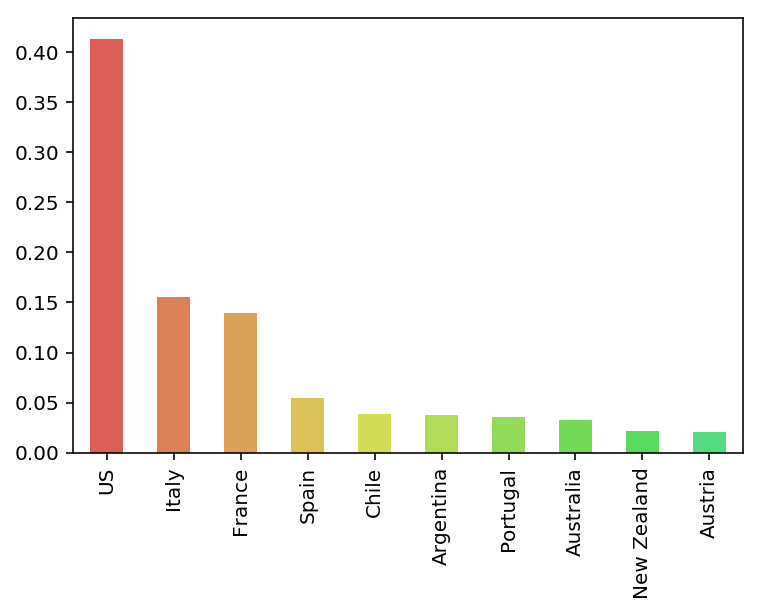

In [95]:
(df['country'].value_counts() / len(df)).head(10).plot.bar()

In [59]:
df['country'].value_counts().median()

47.5

## 地域

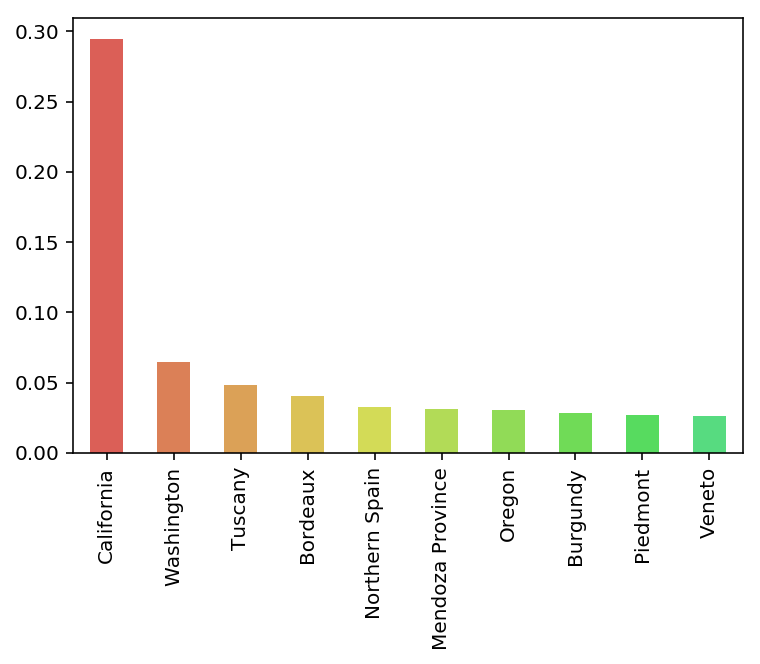

In [96]:
(df['province'].value_counts() / len(df)).head(10).plot.bar()

In [53]:
df['province'].value_counts().median()

12.0

### ワイナリー

ワイナリーごとのレビュー数を見てみる．

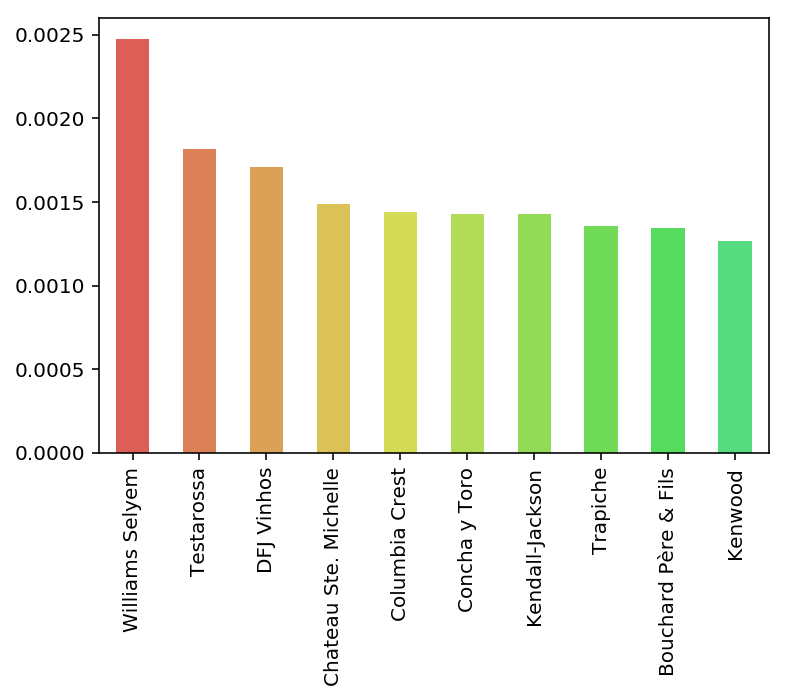

In [97]:
(df['winery'].value_counts() / len(df)).head(10).plot.bar()

In [54]:
df['winery'].value_counts().median()

4.0

### 点数

点数のヒストグラム．

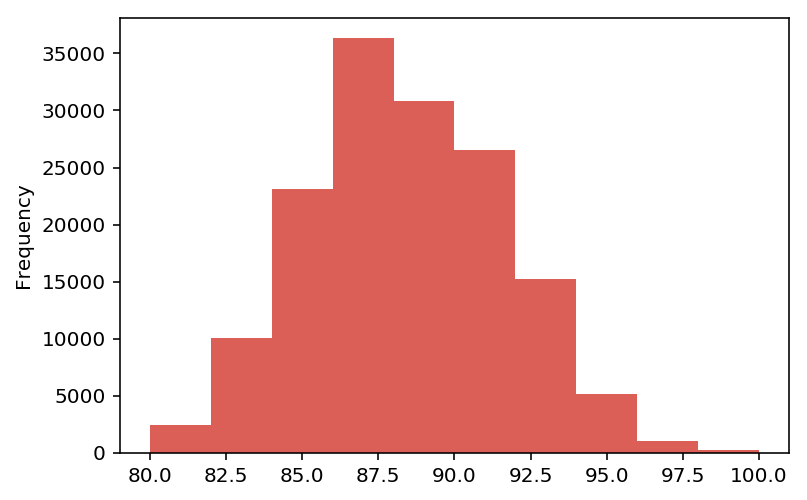

In [98]:
df['points'].plot.hist()

In [15]:
df['points'].median()

88.0

国と点数の関係を見てみる．

In [72]:
df.groupby(['country']).agg(
    {'points': ['mean', 'std', 'count']}).sort_values(
    by=[('points', 'mean')], ascending=False).head(10)

points                 
               mean       std  count
country                             
England   92.888889  1.364225      9
Austria   89.276742  2.557063   3057
France    88.925870  3.199695  21098
Germany   88.626427  2.928762   2452
Italy     88.413664  2.728914  23478
Canada    88.239796  2.467979    196
Slovenia  88.234043  2.007650     94
Morocco   88.166667  2.657180     12
Turkey    88.096154  1.575046     52
Portugal  88.057685  2.881265   5322

地域と点数の関係を見てみる．

In [71]:
df.groupby(['province']).agg(
    {'points': ['mean', 'std', 'count']}).sort_values(
    by=[('points', 'mean')], ascending=False).head(10)

points                
                                     mean       std count
province                                                 
Martinborough Terrace           93.000000       NaN     1
England                         92.888889  1.364225     9
Santa Cruz                      92.500000  1.000000     4
Waitaki Valley                  92.000000       NaN     1
Puente Alto                     91.636364  1.965063    22
Eisenberg                       91.333333  1.154701     3
Vinho da Mesa                   91.333333  0.577350     3
Moscatel de Setúbal             91.000000  1.549193     6
Rapel Valley-Casablanca Valley  91.000000  1.549193     6
Colares                         91.000000       NaN     1

ワイナリーと点数の関係を見てみる．

In [70]:
df.groupby(['winery']).agg(
    {'points': ['mean', 'std', 'count']}).sort_values(
    by=[('points', 'mean')], ascending=False).head(10)

points                
                                    mean       std count
winery                                                  
Sloan                         100.000000  0.000000     2
Mascarello Giuseppe e Figlio   99.000000       NaN     1
Domaine des Lambrays           98.000000       NaN     1
Château Climens                97.111111  1.364225     9
Gandona                        97.000000       NaN     1
Cardinale                      97.000000  3.082207     5
Ovid                           97.000000       NaN     1
Au Sommet                      97.000000  0.000000     3
Château d'Yquem                96.875000  1.885092     8
Harlan Estate                  96.625000  2.326094     8

### 価格

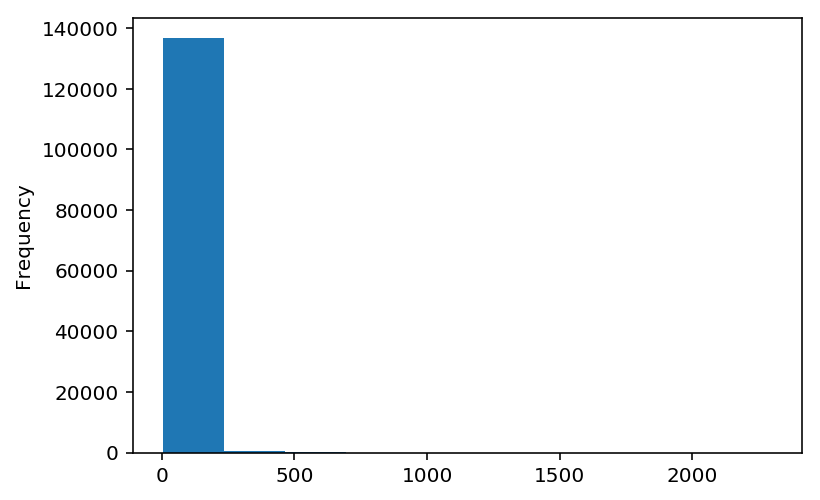

In [62]:
df['price'].plot.hist()

In [69]:
df.groupby(['country']).agg(
    {'price': ['mean', 'std', 'count']}).sort_values(
    by=[('price', 'mean')], ascending=False).head(10)

price                  
                 mean        std  count
country                                
US-France   50.000000        NaN      1
England     47.500000  11.964232      8
France      45.619885  69.697060  14785
Hungary     44.204348  66.264502    230
Luxembourg  40.666667   7.000000      9
Germany     39.011078  56.857128   2347
Italy       37.547913  37.067869  18784
Canada      34.628866  24.267644    194
US          33.653808  24.891343  62139
Israel      31.304918  19.650363    610

In [73]:
df.groupby(['province']).agg(
    {'price': ['mean', 'std', 'count']}).sort_values(
    by=[('price', 'mean')], ascending=False).head(10)

price                  
                                     mean         std count
province                                                   
Santa Cruz                      96.250000    2.500000     4
Champagne                       93.412305  102.510714  1089
Colares                         79.000000         NaN     1
Nevada                          75.000000         NaN     1
Evia                            75.000000    0.000000     2
Ahr                             74.000000   40.354678     5
Moscatel do Douro               74.000000   72.746134     4
Tokaji                          73.154930  108.176265    71
Burgundy                        70.602633   78.317744  3342
Rapel Valley-Casablanca Valley  70.000000    0.000000     6

In [74]:
df.groupby(['winery']).agg(
    {'price': ['mean', 'std', 'count']}).sort_values(
    by=[('price', 'mean')], ascending=False).head(10)

price                   
                                      mean          std count
winery                                                       
Blair                          1029.000000  1391.586145     2
Château Latour                  794.400000   866.023556     5
Masseto                         587.500000    53.033009     2
Château Haut-Brion              569.090909   348.602483    11
Château La Mission Haut-Brion   568.166667   432.002045     6
Krug                            513.250000   447.733179    16
Screaming Eagle                 500.000000     0.000000     2
Château Ausone                  495.000000   502.045815     2
Domaine Perrot-Minot            421.250000    94.989034     4
Château Lafite Rothschild       406.000000   180.360750     5

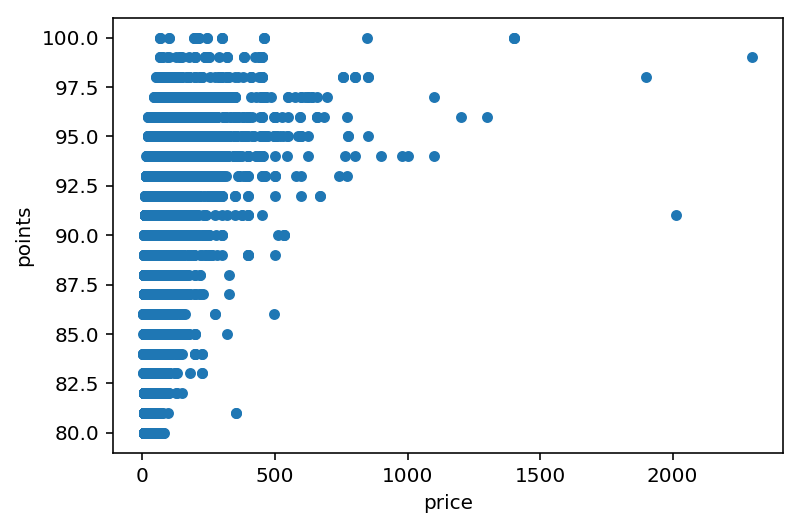

In [77]:
df.plot.scatter(x='price', y='points')

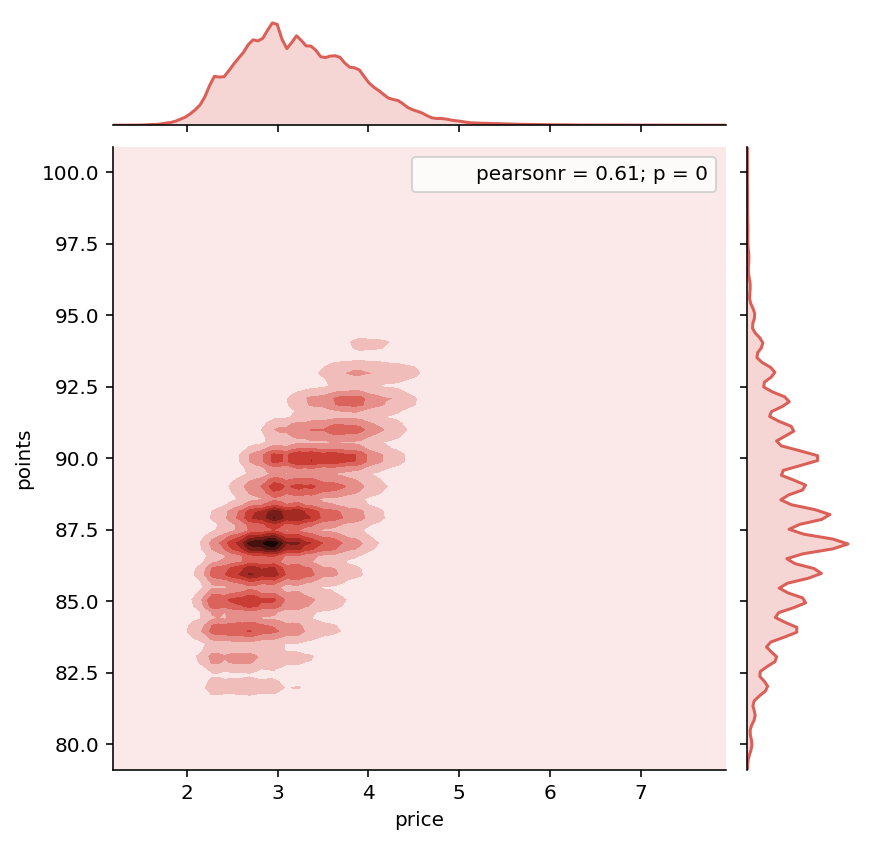

In [99]:
sns.jointplot(np.log(df['price']), df['points'], kind='kde')

おおー．すごいわかりやすい．Priceのメモリを変更したい．

これ使ってみたい．https://seaborn.pydata.org/examples/kde_joyplot.html